In [1]:
%matplotlib inline 
from __future__ import division
from pylab import *
import skimage as ski
from skimage import data, io, filters, exposure, measure
from skimage.filters import rank
from skimage import img_as_float, img_as_ubyte
from skimage.morphology import disk
import skimage.morphology as mp
from skimage import util
from skimage.color import rgb2hsv, hsv2rgb, rgb2gray
from skimage.filters.edges import convolve
from matplotlib import pylab as plt
import numpy as np
from numpy import array
from IPython.display import display
from ipywidgets import interact, interactive, fixed
from ipywidgets import *
from ipykernel.pylab.backend_inline import flush_figures
from multiprocessing.pool import ThreadPool

In [2]:
planesToRead = ['06','07','08','09','10','11']
def drawPlanesImage(i):
    plt.subplot(2,3,i)

In [19]:
planesToRead = ['05']
def drawPlanesImage(i):
    plt.subplot(1,1,i)

In [16]:
planesToRead = ['19','00']
def drawPlanesImage(i):
    plt.subplot(1,2,i)

In [7]:
planesToRead = ['01','02','04','05','06','08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '00']
def drawPlanesImage(i):
    plt.subplot(6,3,i)

In [8]:
planes = [io.imread('./planes/samolot{0}.jpg'.format(i)) for i in planesToRead]
imageList = []
for plane in planes:
    imageList.append(plane)

In [19]:
def increaseEdges(img, lim = 0.3):
    img = mp.dilation(img)
    img[img[:,:] >= lim] = 1
    img[img[:,:] < lim] = 0
    img = mp.erosion(img)

    return img

In [53]:
def getEdges(img, l,a):
    img = rgb2gray(img)
    MIN = 50 / 256
    MAX = 125 / 256

    img = (img - MIN) / (MAX - MIN)
    img = increaseEdges(img, 0.4)
    return img

In [67]:
def getEdges(img, p=1, k=50):
    pp,pk = np.percentile(img, (p,k));
    print("{0} {1}".format(pp, pk))
    img = exposure.rescale_intensity(img, in_range=(pp,pk)) #
    return img
    img = rgb2gray(img)
    res = filters.sobel(img)
    res = increaseEdges(res)
    return res


In [101]:
def getEdges(img, scale=0.15):
   
    #     return img
    K = array([[ 1, 2, 1],
           [ 0, 0, 0],
           [-1,-2,-1]])
    K = K / 4

    K2 = array([[ -1, 0, 1],
               [ -2, 0, 2],
               [-1,0,1]])
    K2 = K2 / 4
    img = rgb2gray(img)
    res1 = np.abs(convolve(img, K))
    res2 = np.abs(convolve(img, K2))
    res = (res1 + res2) / 2
#     print(res)
    return increaseEdges(res, scale)

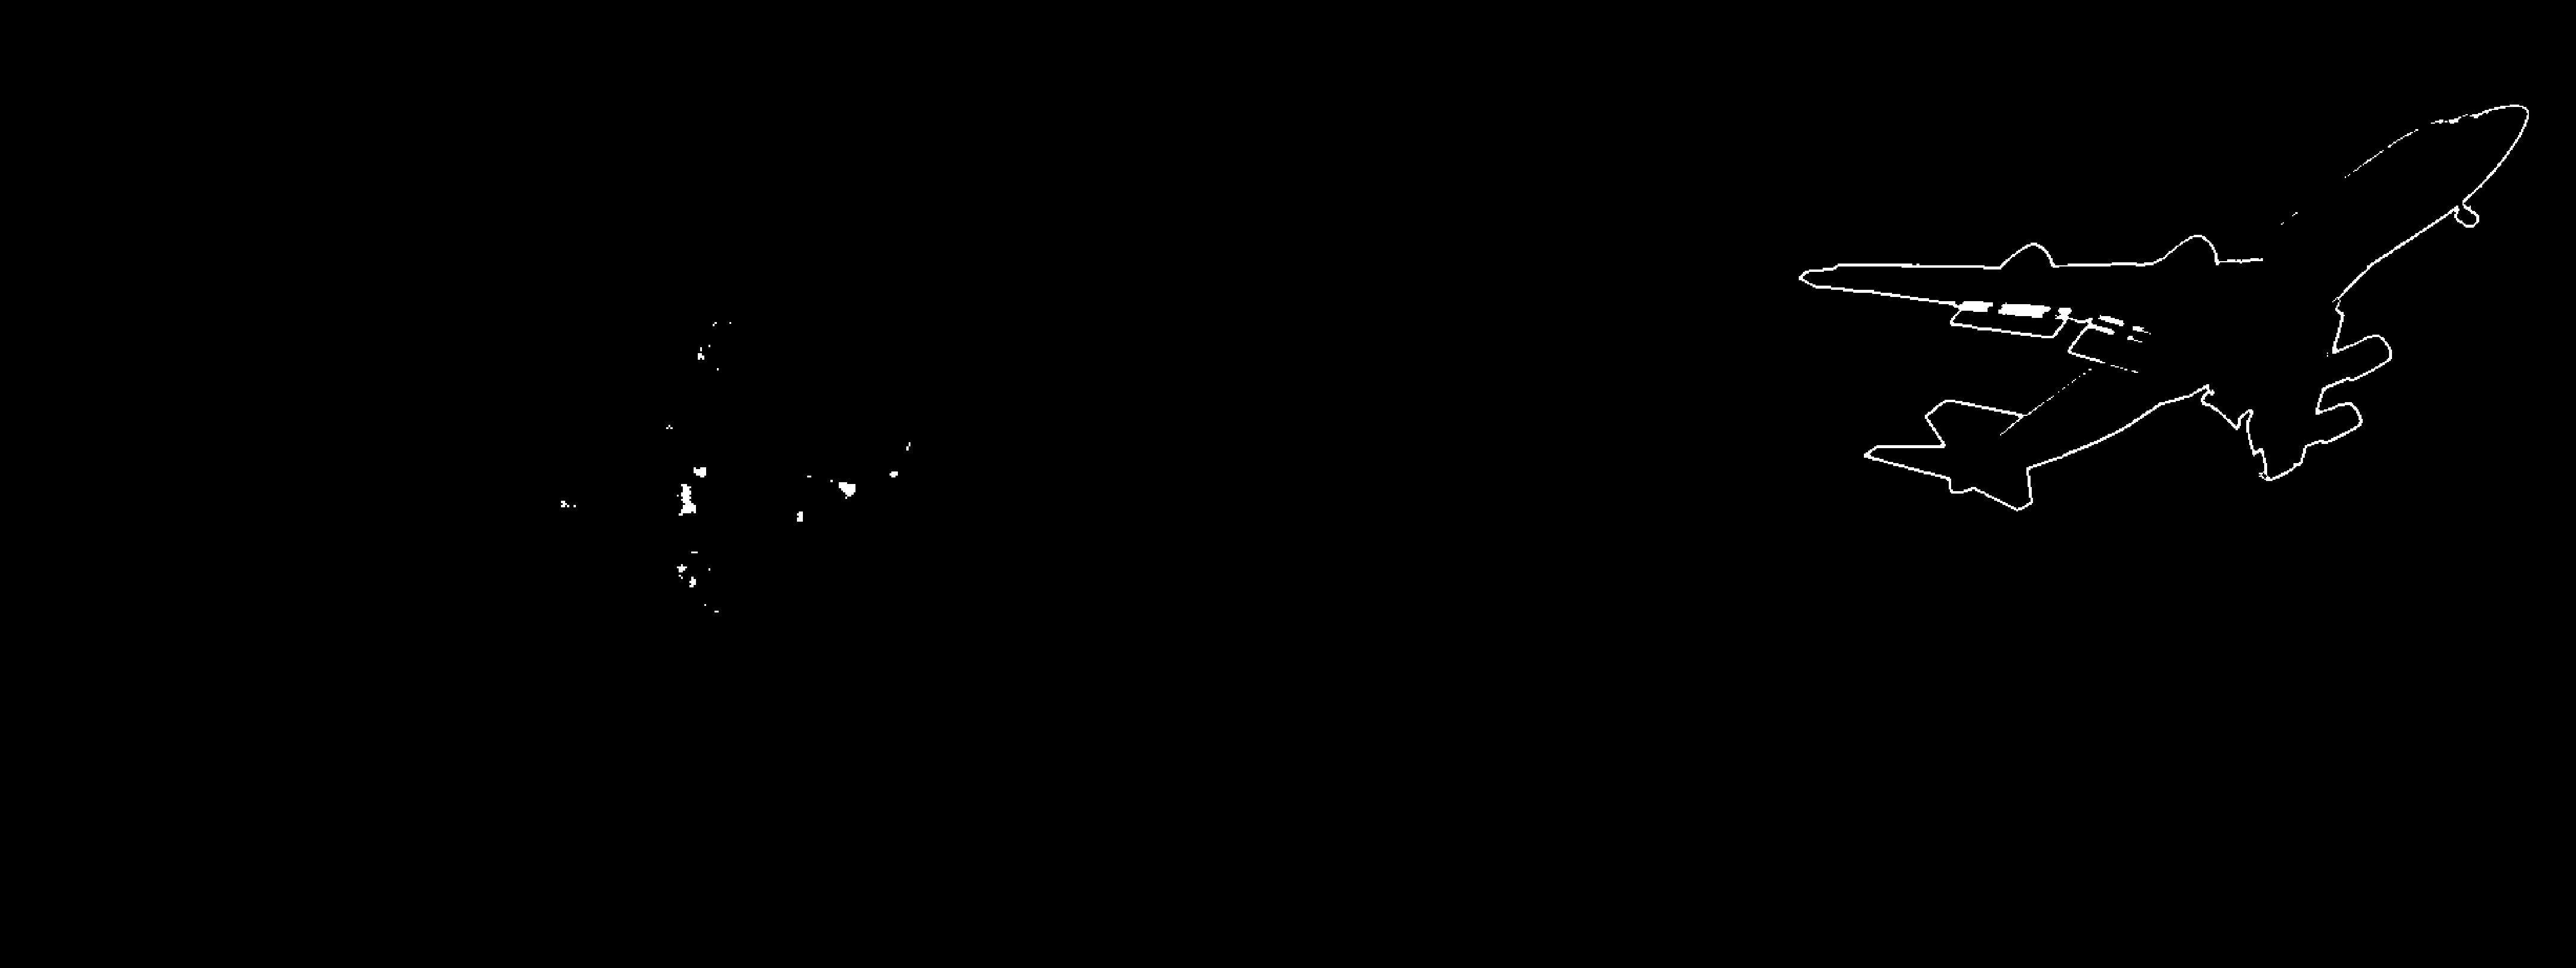

In [60]:
fig = plt.figure(facecolor="black", figsize=(60,60)) # czarne tło
def fun(p=1, k=20):
    i = 1
    for img in imageList:
        drawPlanesImage(i) #tworznie kolejnych subplotów
        res = getEdges(img, p, k)
        plt.imshow(res, cmap = 'gray')
        i += 1
    plt.tight_layout() #Aby obrazy znajdowały się obok siebie
    plt.show()
    fig.savefig("samolotyTemp.pdf")
    plt.close()

fun()

In [116]:

fig = plt.figure(facecolor="black", figsize=(60, 60))  # czarne tło


def fun(p=1, k=20):
    elements = len(imageList)
    imagesProc = []
    pool = ThreadPool(processes=elements)
    count = 0
    for img in imageList:
        count += 1
        asyncRes = pool.apply_async(processImage, ([img]))
        imagesProc.append(asyncRes)
#         print(count)

    for i in range(len(imagesProc)):
        res = imagesProc[i].get()
        drawPlanesImage(i + 1)
        plt.imshow(res)
    plt.tight_layout()  # Aby obrazy znajdowały się obok siebie
    plt.show()
    fig.savefig("samoloty4.pdf")
    plt.close()


fun()

started


NameError: name 'lev' is not defined

In [154]:
def processImage(img, level = 0.085):
    print("started")
    res = getEdges(img)
    res = hsv2rgb(colorImg(res))
    res = addBorders(img, res)
    return res


In [151]:
def replaceAll(objectsMap, oldId, newId):
    objectsMap[objectsMap == oldId] = newId

In [150]:
def findObjects(img):
    maxObjId = 0
    r = 6
    idsMap = [0]
    objectsMap = np.zeros((len(img), len(img[0])))
    for x in range(r, len(img) - r):
        for y in range(r, len(img[x]) - r):
            total = 0
            for i in range(-r, r + 1):
                for j in range(-r, r + 1):
                    total += img[x + i][y + j]
            if (total > 0 and img[x][y] > 0):
                objId = 0
                for i in range(-r, r + 1):
                    for j in range(-r, r + 1):
                        if objId > 0 and objId < objectsMap[x + i][y + j]:
                            replaceAll(objectsMap[:x], objId, objectsMap[x + i][y + j])
                            idsMap[int(objId)] = 0
                        objId = max(objId, objectsMap[x + i][y + j])

                if (objId > 0):
                    objectsMap[x][y] = objId
                    idsMap[int(objId)] += 1
                else:
                    maxObjId += 1
                    idsMap.append(1)
                    objectsMap[x][y] = maxObjId
                    
    lev = max(idsMap) / 7               
    objCords = [{"left": len(img),
                 "right": 0,
                 "top": len(img[0]),
                 "bottom": 0}] * len(idsMap)
    
    
    for i in range(len(objectsMap)):
        for j in range(len(objectsMap[i])):
            objId = int(objectsMap[i][j])
            if idsMap[objId] < lev:
                objectsMap[i][j] = 0
                objCords[objId] = 0
            else:
                objCords[objId]["left"] = min(objCords[objId]["left"], i)
                objCords[objId]["right"] = max(objCords[objId]["right"], i)
                objCords[objId]["top"] = min(objCords[objId]["top"], j)
                objCords[objId]["bottom"] = max(objCords[objId]["bottom"], j)

    for i in range(len(objCords)):
        if objCords[i] != 0:
            x = (objCords[i]["left"] + objCords[objId]["right"]) / 2
            y = (objCords[objId]["top"] + objCords[objId]["bottom"]) / 2
            for i in range(-r , r + 1):
                for j in range(-r, r + 1):
                    objectsMap[x+i][y+j] = idsMap[i]
            
    return objectsMap, maxObjId


def colorImg(img):
    objectsMap, maxObjId = findObjects(img)
    colorStep = 360 / maxObjId
    colorsMap = []
    for i in range(len(img)):
        colorsMap.append([])
        for j in range(len(img[i])):
            h = colorStep * objectsMap[i][j]
            if not h == 0:
                colorsMap[i].append([h, 1, 1])
            else:
                colorsMap[i].append([0, 0, 0])
    return colorsMap


In [149]:
def addBorders(original, borders):
    for i in range(len(original)):
        for j in range(len(original[i])):
            if sum(borders[i][j]) > 0.1:
                original[i][j] = borders[i][j] * 255
    return original


In [34]:
def getEdges(image, level = 0.3, gamma = 0.9):
#     intensityP = 5
#     intensityK = 100-intensityP
#     pp,pk = np.percentile(image,(intensityP,intensityK));
#     image = exposure.rescale_intensity(image,in_range=(pp,pk))
    blackWhite = rgb2gray(image)
    blackWhite = blackWhite ** gamma
    blackWhite = filters.sobel(blackWhite)
    
#     blackWhite = blackWhite ** 0.7
#     blackWhite = filters.sobel(blackWhite)
    blackWhite = mp.dilation(blackWhite)
    blackWhite = mp.erosion(blackWhite)

    blackWhite[blackWhite[:,:] >= level] = 1
    blackWhite[blackWhite[:,:] < level] = 0
    blackWhite = filters.median(blackWhite, disk(2))
    return blackWhite

In [201]:
def getEdges(img, x, sig=3): #gama 0.7 sig = 4.65
    img = rgb2gray(img)
    from skimage import feature
    img = img ** 0.7
    img = ski.feature.canny(img, sigma=sig)
    img = mp.dilation(img)
    return img

In [202]:
def drawPlotsBlack(level=0.087, gamma = 4.65): #0.087 1.1
    fig = plt.figure(facecolor="black", figsize=(60,60)) # czarne tło
    i = 1
    for img in imageList:
        drawPlanesImage(i) #tworznie kolejnych subplotów
        image = getEdges(img, level, gamma) #znajdywanie krawedzi
        plt.imshow(image, cmap = 'gray')
        i +=1 #kolejny obraz
    plt.tight_layout() #Aby obrazy znajdowały się obok siebie
    plt.show()
    fig.savefig("samoloty3.pdf",facecolor="black")
    plt.close()

interact(drawPlotsBlack, level=(0.06,0.3,0.005), gamma=(3,15,0.2))

interactive(children=(FloatSlider(value=0.087, description='level', max=0.3, min=0.06, step=0.005), FloatSlider(value=4.65, description='gamma', max=15.0, min=3.0, step=0.2), Output()), _dom_classes=('widget-interact',))

<function __main__.drawPlotsBlack>